<a href="https://colab.research.google.com/github/thalankiabhishek/AustRainia/blob/main/Will_it_rain_tomorrow%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---
## Tasks:
---
1.   What is the most minimum temperature that has ever been recorded?
2.   What is the largest amount of rainfall that has ever been recorded.

3.   Predict whether or not it will rain tomorrow by training a binary classification model on target RainTomorrow.

---
### Variable Description
---
> Date---The date of observation

> Location---The common name of the location of the weather station

> MinTemp, MaxTemp --- Temperature in degrees celsius

> Rainfall---The amount of rainfall recorded for the day in mm

> Evaporation---The so-called Class A pan evaporation (mm) in the 24 hours to 9am

> Sunshine---The number of hours of bright sunshine in the day.

> WindGustDir---The direction of the strongest wind gust in the 24 hours to midnight

> WindGustSpeed---The speed (km/h) of the strongest wind gust in the 24 hours to midnight

> WindDir9am, WindDir3pm---Direction of the wind at 9am & 3pm

> WindSpeed9am, WindSpeed3pm---Wind speed (km/hr) averaged over 10 minutes prior to 9am & 3pm

> Humidity9am, Humidity3pm---Humidity (percent) at 9am & 3pm

> Pressure9am, Pressure3pm---Atmospheric pressure (hpa) reduced to mean sea level at 9am & 3pm

> Cloud9am, Cloud3pm---Fraction of sky obscured by cloud at 9am & 3pm. 
This is measured in "oktas", which are a unit of eigths. It records how many eigths of the sky are obscured by cloud. A 0 measure indicates completely clear sky whilst an 8 indicates that it is completely overcast.

> Temp9am, Temp3pm---Temperature (degrees C) at 9am & 3pm

> RainToday---Boolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0

> RISK_MM---The amount of next day rain in mm. Used to create response variable RainTomorrow. A kind of measure of the "risk".

> RainTomorrow---The target variable. Did it rain tomorrow? References This total dataset is taken from following kaggle reference.

---
# Data Pre-Processing
---

In [ ]:
#@title Download Data
!wget https://github.com/amounsey/AustraliaRainPrediction/raw/master/data/weather.csv

--2020-08-14 08:02:17--  https://github.com/amounsey/AustraliaRainPrediction/raw/master/data/weather.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/amounsey/AustraliaRainPrediction/master/data/weather.csv [following]
--2020-08-14 08:02:17--  https://raw.githubusercontent.com/amounsey/AustraliaRainPrediction/master/data/weather.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14167671 (14M) [text/plain]
Saving to: ‘weather.csv’

weather.csv         100%[===================>]  13.51M  24.0MB/s    in 0.6s    

2020-08-14 08:02:18 (24.0 MB/s) - ‘weather.csv’ saved [14167671/14167671]



In [ ]:
#@title Import Libraries
import pandas as pd
from tqdm.notebook import tqdm
import os, re
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set(style='darkgrid', palette='deep')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('weather.csv', parse_dates=['Date'], infer_datetime_format=True, index_col='Date')
df.head()

Location  MinTemp  MaxTemp  ...  RainToday  RISK_MM  RainTomorrow
Date                                   ...                                  
2008-01-12   Albury     13.4     22.9  ...         No      0.0            No
2008-02-12   Albury      7.4     25.1  ...         No      0.0            No
2008-03-12   Albury     12.9     25.7  ...         No      0.0            No
2008-04-12   Albury      9.2     28.0  ...         No      1.0            No
2008-05-12   Albury     17.5     32.3  ...         No      0.2            No

[5 rows x 23 columns]

# Exploratory Data Analysis

### EDA with Categorical Variables

There are 6 Categorical Variables in DataSet


Columns Cardinality                                             Labels
0      Location          49  [Albury, BadgerysCreek, Cobar, CoffsHarbour, M...
1   WindGustDir          16  [W, WNW, WSW, NE, NNW, N, NNE, SW, ENE, SSE, S...
2    WindDir9am          16  [W, NNW, SE, ENE, SW, SSE, S, NE, nan, SSW, N,...
3    WindDir3pm          16  [WNW, WSW, E, NW, W, SSE, ESE, ENE, NNW, SSW, ...
4     RainToday           2                                     [No, Yes, nan]
5  RainTomorrow           2                                          [No, Yes]

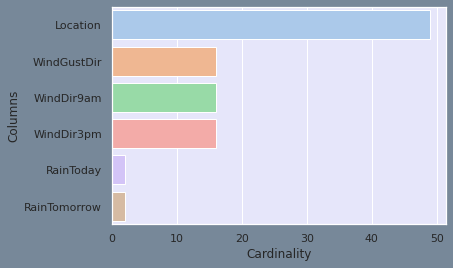

In [ ]:
#@title ***Cardinality*** in ***Categorical Variables*** in DataSet
#@markdown The cardinality of a set is a measure of the "*number of elements*" of the set.

categorical = [column for column in df.columns if df[column].dtype=='O']

print(f"There are {len(categorical)} Categorical Variables in DataSet")

cardinality = pd.DataFrame(columns = ['Columns', 'Cardinality', 'Labels'])

for column in df[categorical].columns:
  cardinality = cardinality.append({'Columns':column, 
                                    'Cardinality':df[column].nunique(), 
                                    'Labels':df[column].unique()}, 
                                    ignore_index=True)
sns.barplot(x='Cardinality', y='Columns', data=cardinality)
cardinality

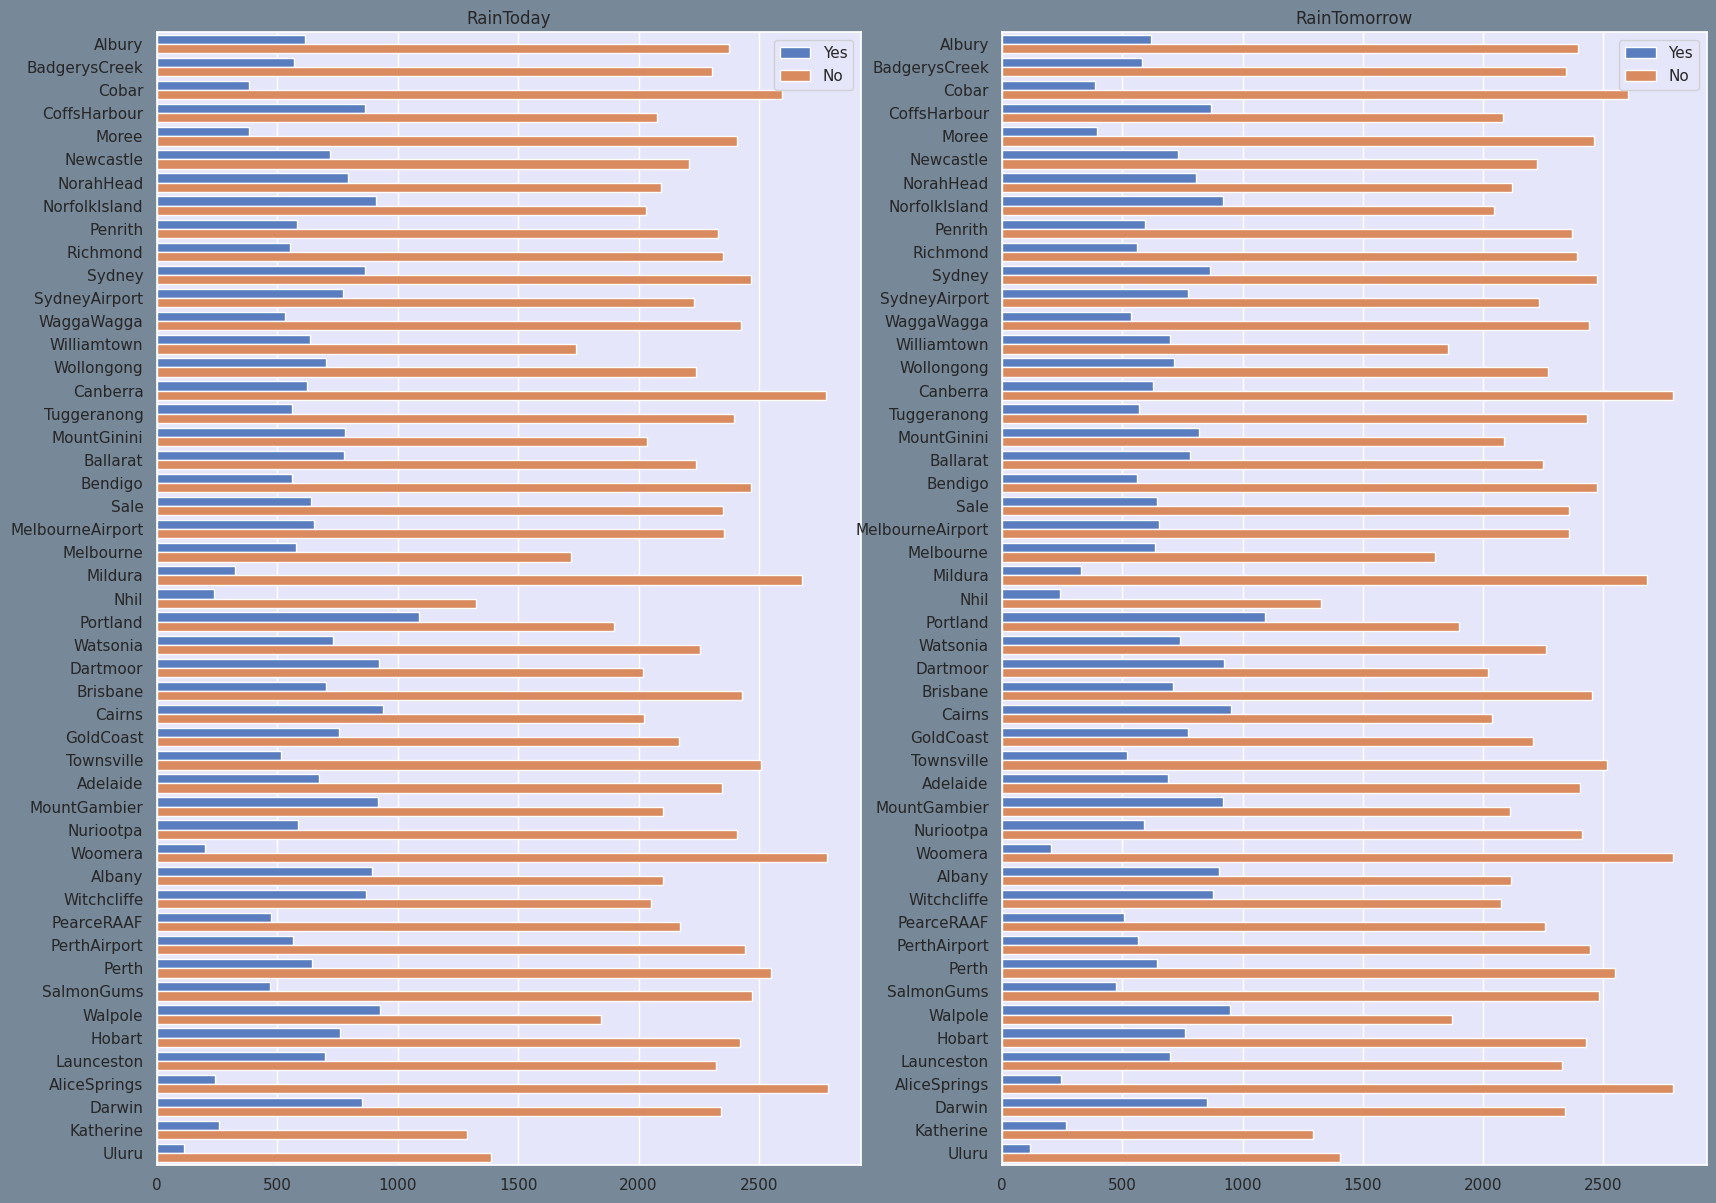

In [ ]:
#@title Exploring if it rained today or if it is going to rain tomorrow... 
f, a = plt.subplots(nrows=1, ncols=2, figsize = (20, 15), dpi=100)
for ax, column in zip(a.flatten(), categorical[-2:]):
  sns.countplot(y = 'Location', data = df, palette='muted', ax=ax, hue=column, hue_order=['Yes', 'No'])
  ax.set_title(f'{column}')
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.legend()

## EDA with Numerical Variables

### ***Outlier Detection*** in Numerical Variables in DataSet
What is Interquartile Range?

In descriptive statistics, the interquartile range (IQR) is a measure of statistical dispersion, being equal to the difference between the third quartile (Q3) and first quartile (Q1), i.e., IQR = Q3 – Q1

where first quartile/lower quartile (Q1) = 25th percentile of the data

third quartile/upper quartile = 75th percentile of the data

In [ ]:
numerical = [column for column in df.columns if df[column].dtype!='O']

print(f"There are {len(numerical)} Numerical Variables in DataSet")

outlier_df = pd.DataFrame(columns=['Columns', 'Lower Limit', 'Upper Limit'])
for column in df[numerical].columns:
    interquantile_range = df[column].quantile(0.75) - df[column].quantile(0.25)
    lower_limit = df[column].quantile(0.25) - (interquantile_range * 3)
    upper_limit = df[column].quantile(0.75) + (interquantile_range * 3)
    outlier_df = outlier_df.append({'Columns':column, 'Lower Limit': lower_limit, 'Upper Limit':upper_limit}, ignore_index=True)
outlier_df


There are 17 Numerical Variables in DataSet


Columns  Lower Limit  Upper Limit
0         MinTemp        -20.0         44.4
1         MaxTemp        -13.0         59.1
2        Rainfall         -2.4          3.2
3     Evaporation        -11.8         21.8
4        Sunshine        -12.2         27.7
5   WindGustSpeed        -20.0         99.0
6    WindSpeed9am        -29.0         55.0
7    WindSpeed3pm        -20.0         57.0
8     Humidity9am        -21.0        161.0
9     Humidity3pm        -50.0        153.0
10    Pressure9am        984.4       1050.9
11    Pressure3pm        981.6       1048.8
12       Cloud9am        -17.0         25.0
13       Cloud3pm        -13.0         22.0
14        Temp9am        -15.6         49.5
15        Temp3pm        -12.8         55.8
16        RISK_MM         -2.4          3.2

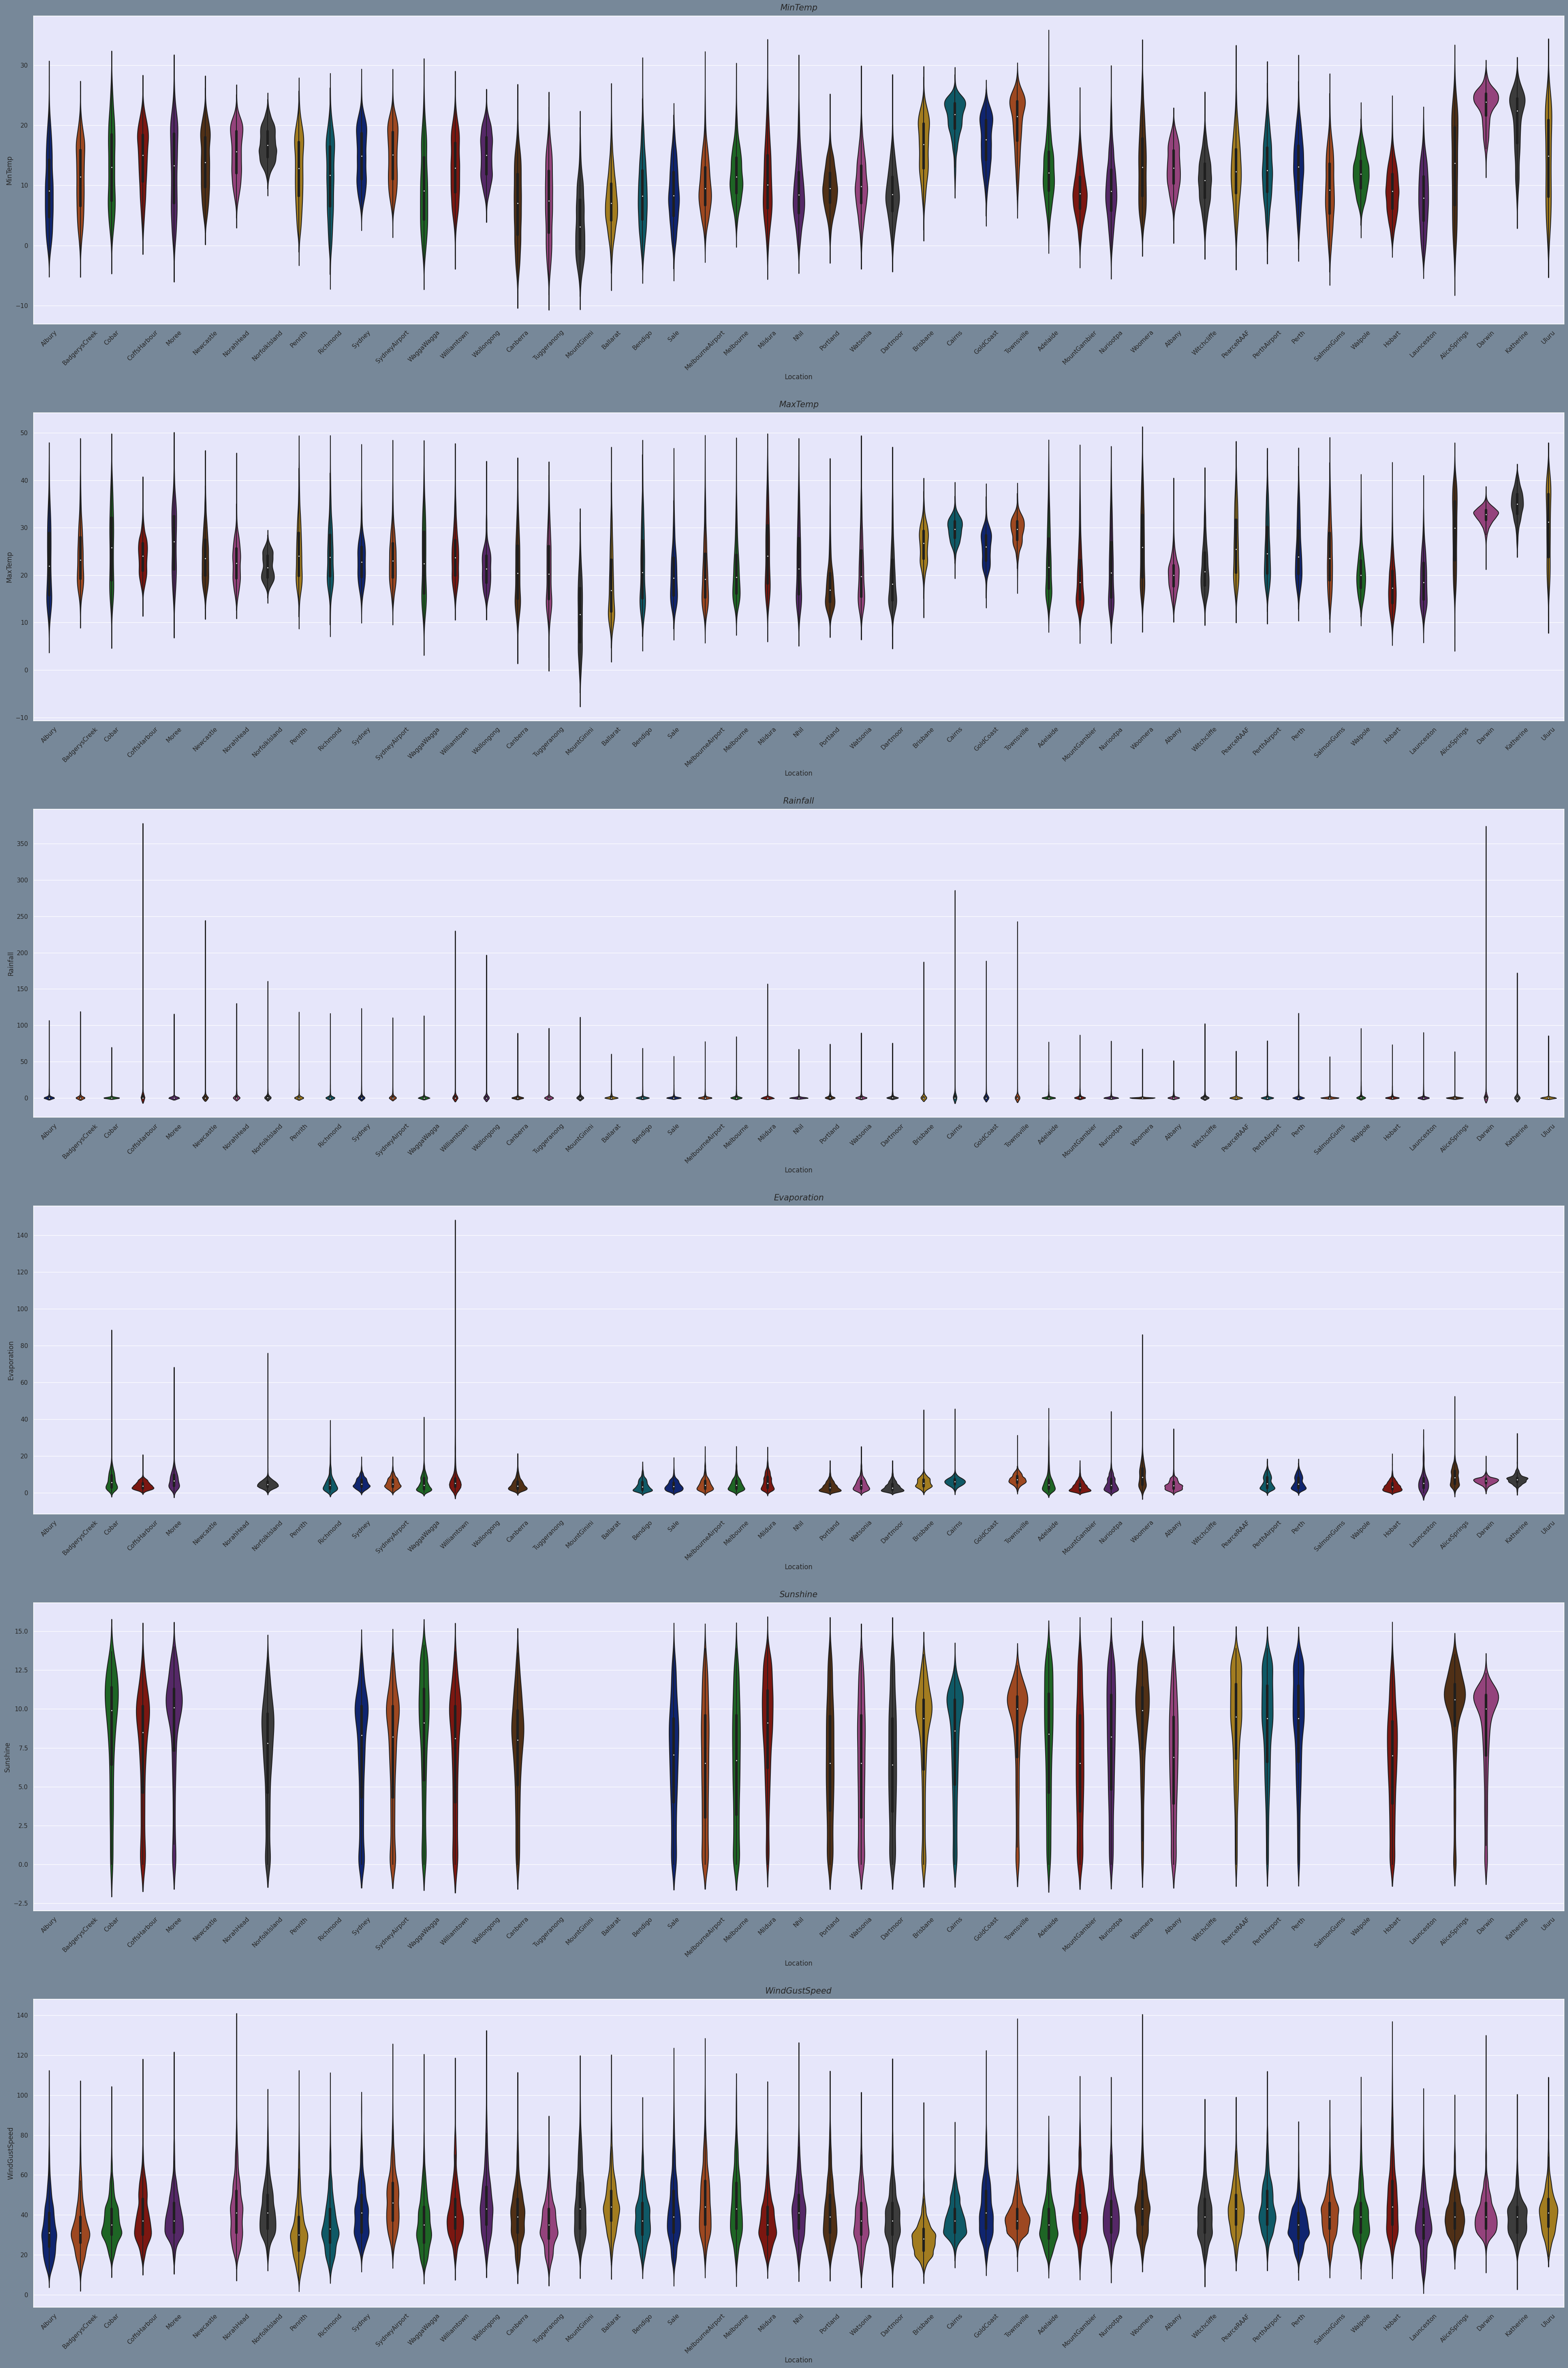

In [ ]:
#@title Distribution of Numerical Variables 
f, a = plt.subplots(nrows=6, ncols=1, figsize=(40, 60), dpi=100)
for c, ax in zip(numerical, a.flatten()):

  sns.violinplot(x = 'Location', y = c, data=df, ax=ax, palette='dark', split=True)
  # sns.boxenplot(x = df.index.year, y = c, data=df, ax=ax, palette='icefire')
  # sns.stripplot(x = df.index.year, y = c, data=df, ax=ax, palette='Greys_d')
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  ax.set_title(c, fontsize=15, fontstyle='oblique', pad=10)
  ax.set_xlabel('Location')
f.tight_layout(pad=3.0)

In [ ]:
#@title ***Duplicity***
print(len(df) - len(df.drop_duplicates()))
df.drop_duplicates(inplace=True)

41


In [ ]:
#@title Handling ***Null*** Values in Variables
for col in tqdm(df.columns.tolist()[1:]):
  if df[col].dtype == float:
    df[col] = df[col].fillna(df[col].mean())

df.dropna(how='any', inplace=True)
df.isna().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RISK_MM          0
RainTomorrow     0
dtype: int64

In [ ]:
#@title Scraping Years and Months from Index
df['Year'] = df.index.strftime('%Y')
df['Month'] = df.index.strftime('%B')

df['Rain_Tomorrow'] = df.RainTomorrow
df.drop('RainTomorrow', 1, inplace = True)

In [ ]:
#@title Descriptive Statistics
round(df.describe(), 2)

MinTemp    MaxTemp   Rainfall  ...    Temp9am    Temp3pm    RISK_MM
count  123710.00  123710.00  123710.00  ...  123710.00  123710.00  123710.00
mean       12.41      23.47       2.38  ...      17.27      21.90       2.32
std         6.37       7.21       8.53  ...       6.48       7.01       8.43
min        -8.50      -4.80       0.00  ...      -7.20      -5.40       0.00
25%         7.80      18.10       0.00  ...      12.50      16.80       0.00
50%        12.20      23.00       0.00  ...      16.99      21.50       0.00
75%        17.00      28.60       0.80  ...      21.90      26.70       0.60
max        33.90      48.10     367.60  ...      40.20      46.70     371.00

[8 rows x 17 columns]

<Figure size 600x400 with 0 Axes>

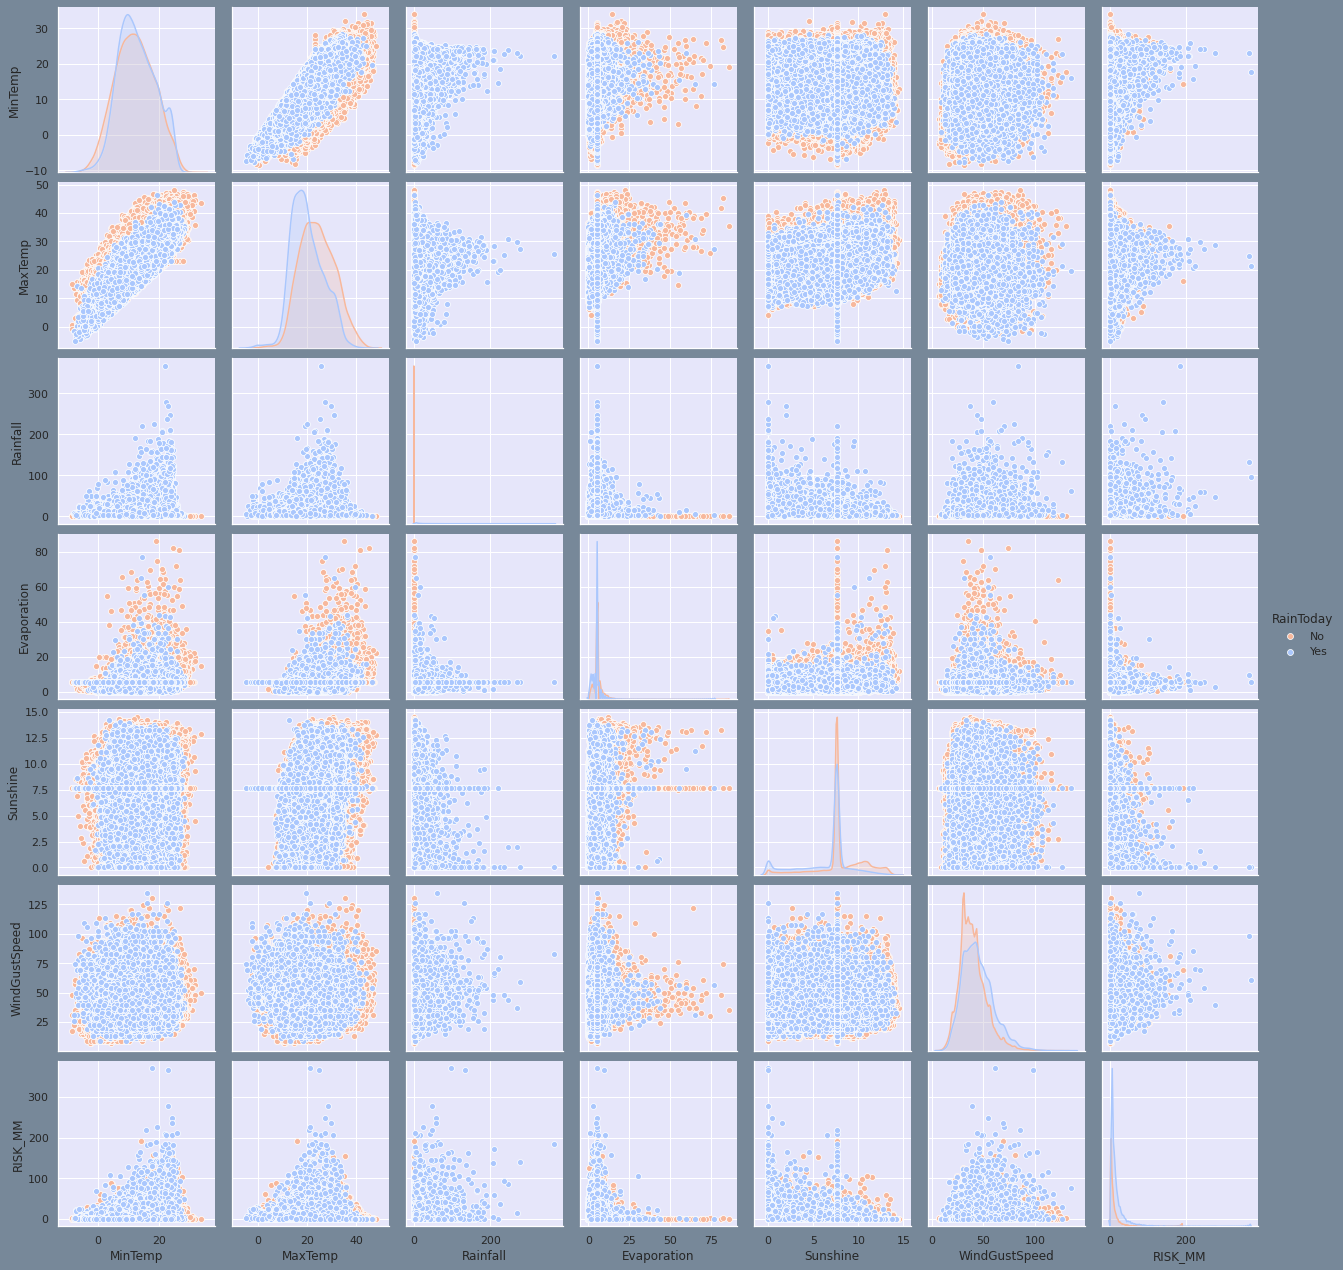

In [ ]:
plt.figure(dpi=100)
sns.pairplot(data = df, hue='RainToday', kind='scatter', diag_kind='kde', palette='coolwarm_r',
             vars=['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'RISK_MM'])



---

# Data Visualisation

---



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid', palette = 'pastel', 
        rc = {'figure.facecolor':'lightslategrey', 'axes.facecolor':'lavender'})

In [ ]:
df.head()

Location  MinTemp  MaxTemp  ...  Year     Month  Rain_Tomorrow
Date                                   ...                               
2008-01-12   Albury     13.4     22.9  ...  2008   January             No
2008-02-12   Albury      7.4     25.1  ...  2008  February             No
2008-03-12   Albury     12.9     25.7  ...  2008     March             No
2008-04-12   Albury      9.2     28.0  ...  2008     April             No
2008-05-12   Albury     17.5     32.3  ...  2008       May             No

[5 rows x 25 columns]

In [ ]:
px.pie(df[df.Rainfall>=df.Rainfall.quantile(q=0.999)].groupby('Location').size().nlargest(10).reset_index(name='Count'), 
       values='Count', names='Location', title='Highest Rainfall 2007 through 2017', 
       color_discrete_sequence=px.colors.qualitative.Pastel, hole=0.7)

In [ ]:
f = px.scatter(data_frame= df[df.Rainfall>=df.Rainfall.quantile(q=0.999)], 
               x ='Location', y= 'Rainfall', color= "Month", size= 'Rainfall', 
               log_y= True, opacity= 0.5, 
               hover_name= 'Location', hover_data= ['Month', 'Year', 'Rainfall'])

f.update_layout(showlegend=False)
f.update_yaxes(showspikes=True, spikesnap="cursor", spikemode="toaxis", spikethickness=1, spikedash='solid')

In [ ]:
df.resample('QS').mean().reset_index()

Date    MinTemp    MaxTemp  ...    Temp3pm   RISK_MM    AvgTemp
0  2007-01-01  13.166667  24.250000  ...  21.816667  9.666667  18.708333
1  2007-04-01  11.866667  20.600000  ...  19.066667  0.500000  16.233333
2  2007-07-01  11.983333  23.016667  ...  21.533333  3.366667  17.500000
3  2007-10-01  12.632558  26.118605  ...  24.565116  2.679070  19.375581
4  2008-01-01  12.187215  23.569528  ...  22.129224  1.169863  17.878371
5  2008-04-01  10.342056  21.837850  ...  20.238785  1.519626  16.089953
6  2008-07-01  10.028762  20.812571  ...  19.381333  1.590857  15.420667
7  2008-10-01  14.771166  25.486894  ...  23.750590  2.901180  20.129030
8  2009-01-01  15.042786  26.814773  ...  25.187280  2.437265  20.928779
9  2009-04-01  10.772185  21.133198  ...  19.826900  2.259665  15.952692
10 2009-07-01  10.042709  20.802204  ...  19.392339  1.798926  15.422456
11 2009-10-01  13.851616  25.691430  ...  23.956271  2.169826  19.771523
12 2010-01-01  15.110503  26.308137  ...  24.703965  3.005862  20.709320
13 2010-04-01  11.062324  21.097502  ...  19.778506  2.628052  16.079913
14 2010-07-01   9.996189  20.133585  ...  18.764180  2.186502  15.064887
15 2010-10-01  13.287590  23.905661  ...  22.229366  3.165044  18.596625
16 2011-01-01  15.276660  25.874021  ...  24.329660  2.912670  20.575341
17 2011-04-01  10.163355  20.087267  ...  18.757920  2.594937  15.125311
18 2011-07-01   9.678079  20.311588  ...  18.957938  2.699008  14.994834
19 2011-10-01  13.499890  24.042406  ...  22.483283  2.847130  18.771148
20 2012-01-01  14.713438  25.726376  ...  24.234135  3.774061  20.219907
21 2012-04-01  10.311557  20.897318  ...  19.614421  2.381347  15.604438
22 2012-07-01   9.188876  19.986554  ...  18.593749  1.596359  14.587715
23 2012-10-01  11.811883  23.860402  ...  22.207281  1.678738  17.836142
24 2013-01-01  14.351523  25.856187  ...  24.136123  2.957637  20.103855
25 2013-04-01  10.623930  21.439928  ...  20.175770  2.141952  16.031929
26 2013-07-01  10.463726  21.650875  ...  20.165572  2.051829  16.057300
27 2013-10-01  13.466596  25.524314  ...  23.745217  1.890784  19.495455
28 2014-01-01  15.257617  26.712517  ...  24.997911  2.250729  20.985067
29 2014-04-01  11.333613  21.932610  ...  20.592081  1.963760  16.633112
30 2014-07-01   9.984835  21.421025  ...  20.071655  1.848811  15.702930
31 2014-10-01  13.767368  25.999795  ...  24.239321  1.590883  19.883582
32 2015-01-01  14.759253  26.389585  ...  24.686963  2.392114  20.574419
33 2015-04-01  10.876611  21.355006  ...  19.979289  2.332810  16.115809
34 2015-07-01   9.816237  20.725112  ...  19.187604  1.721711  15.270674
35 2015-10-01  14.101989  26.387674  ...  24.401471  1.783607  20.244831
36 2016-01-01  15.288125  26.414799  ...  24.486859  2.487119  20.851462
37 2016-04-01  11.576315  22.027626  ...  20.430110  2.718893  16.801971
38 2016-07-01  10.324000  20.552472  ...  18.869486  2.547663  15.438236
39 2016-10-01  13.299447  24.989412  ...  22.963600  1.671928  19.144430
40 2017-01-01  16.110578  27.866023  ...  25.854391  2.881361  21.988300
41 2017-04-01  11.643893  22.337690  ...  20.853473  2.065961  16.990791
42 2017-07-01  14.153618  25.815702  ...  24.032778  2.920413  19.984660
43 2017-10-01  13.978806  25.640784  ...  23.895386  1.942745  19.809795

[44 rows x 18 columns]

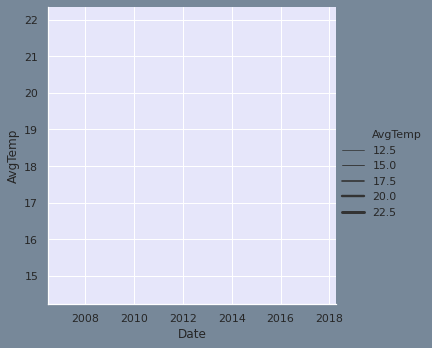

In [ ]:
sns.relplot(data= df.resample('QS').mean().reset_index(), x='Date', y='AvgTemp', size='AvgTemp', kind='line')

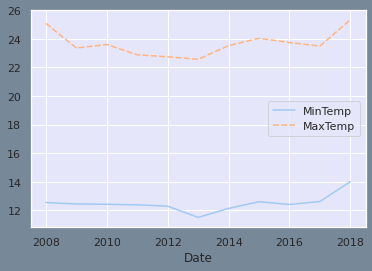

In [ ]:
sns.lineplot(data= df[['MinTemp', 'MaxTemp']].resample('Y').mean(), estimator='min')
# sns.scatterplot(data= df.resample('QS').mean().reset_index(), x='Date', y='AvgTemp')
# sns.lineplot(data= df.resample('QS').mean().reset_index(), x='Date', y='MaxTemp')

In [ ]:
px.pie(df[df.MinTemp>=df.MinTemp.quantile(q=0.999)].groupby('Location').size().nlargest(10).reset_index(name='Count'), 
       values='Count', names='Location', title='Highest Rainfall 2007 through 2017', 
       color_discrete_sequence=px.colors.qualitative.Pastel, hole=0.7)

In [ ]:
a = df.groupby(['Year', 'Location'])[['MinTemp', 'MaxTemp']].mean().reset_index()
a

Year      Location    MinTemp    MaxTemp
0    2007      Canberra  12.545902  25.086885
1    2008      Adelaide  11.252381  21.464626
2    2008        Albury  13.703571  27.171429
3    2008  AliceSprings  20.823333  34.663333
4    2008      Ballarat   8.770968  21.377419
..    ...           ...        ...        ...
425  2017      Watsonia  11.040942  22.891489
426  2017   Williamtown  15.518293  25.290244
427  2017   Witchcliffe  11.845860  23.165775
428  2017    Wollongong  17.092903  23.174194
429  2017       Woomera  15.053179  28.292486

[430 rows x 4 columns]

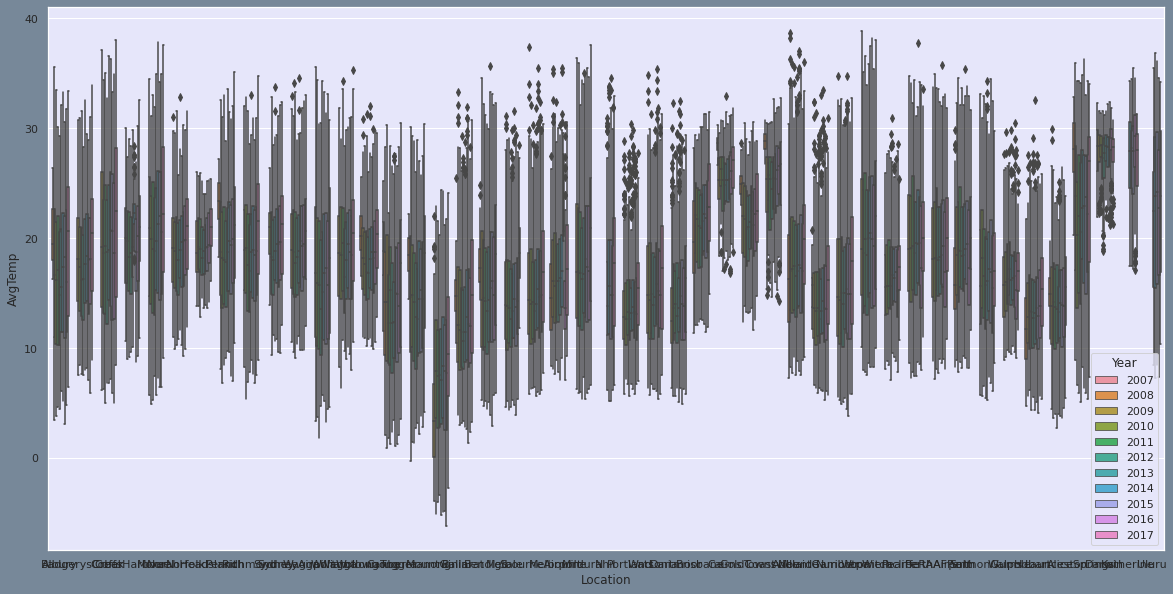

In [ ]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=df, y='AvgTemp',x='Location', hue='Year')

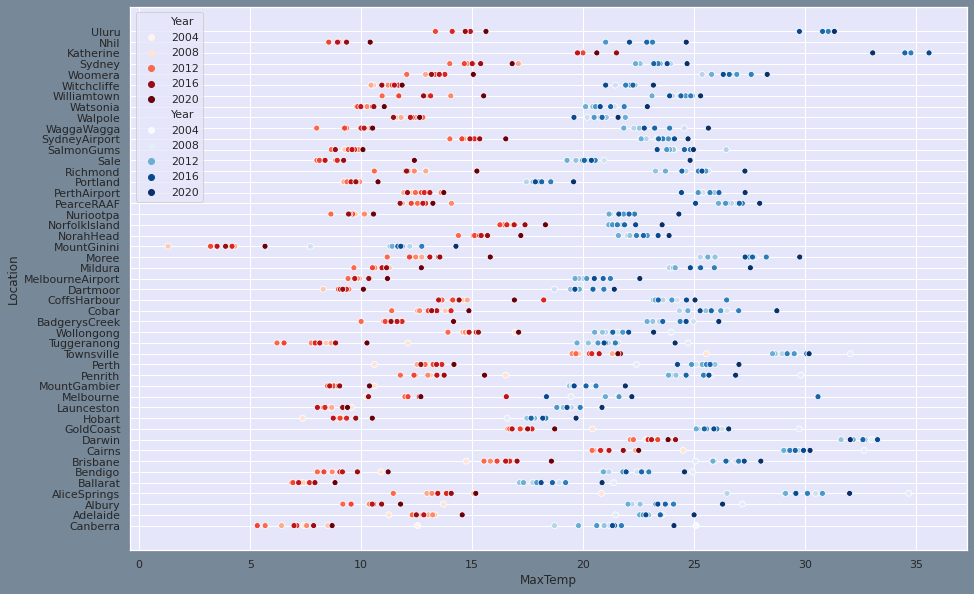

In [ ]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=a, x= 'MinTemp', y= 'Location', hue='Year', palette='Reds')
sns.scatterplot(data=a, x= 'MaxTemp', y= 'Location', hue='Year', palette='Blues')

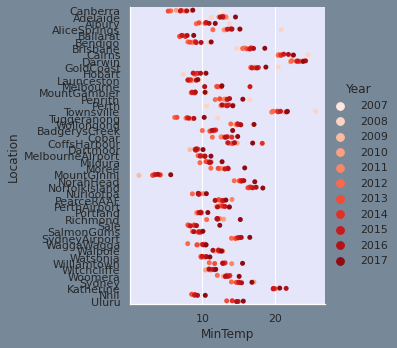

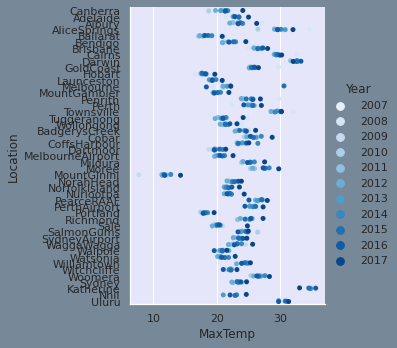

In [ ]:
sns.catplot(data=a, x= 'MinTemp', y= 'Location', hue='Year', palette='Reds')
sns.catplot(data=a, x= 'MaxTemp', y= 'Location', hue='Year', palette='Blues')

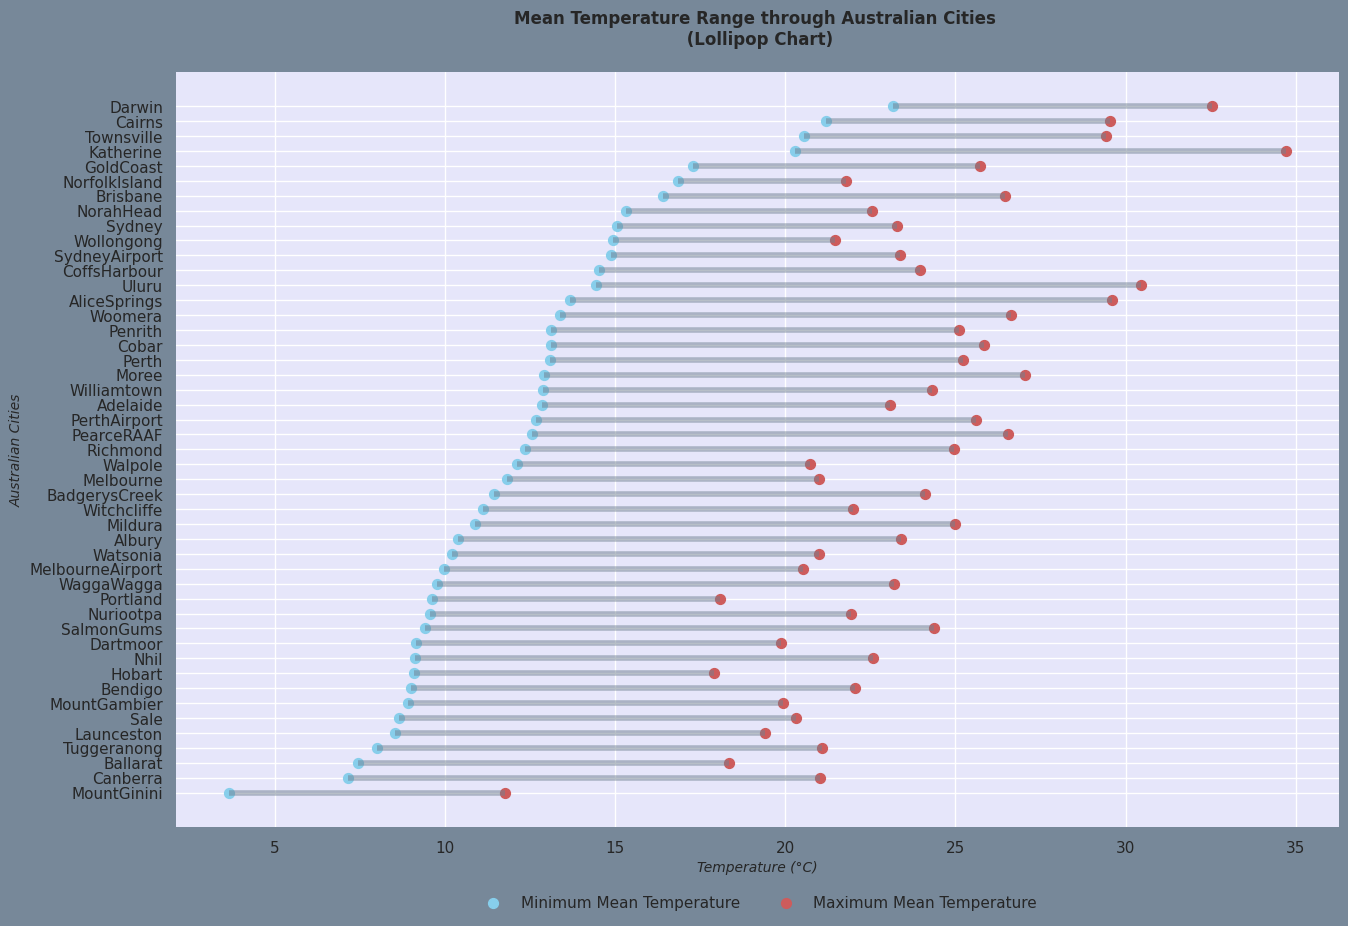

In [ ]:
ordered_df = df.groupby('Location')[['MinTemp', 'MaxTemp']].mean().sort_values('MinTemp')

plt.figure(figsize=(15, 10), dpi=100)
plt.scatter(ordered_df.MinTemp, ordered_df.index, s=50, color='skyblue', label='Minimum Mean Temperature')
plt.scatter(ordered_df.MaxTemp, ordered_df.index, s=50, color='indianred', label='Maximum Mean Temperature')
plt.hlines(y=ordered_df.index, xmin=ordered_df.MinTemp, xmax=ordered_df.MaxTemp, colors='slategrey', alpha=0.5, linewidth=4)

plt.legend(ncol=2, frameon=False, bbox_to_anchor=(0.5, -0.1), loc='center')
plt.xlabel('Temperature (°C)', style="oblique", fontsize=10)
plt.ylabel('Australian Cities', style="oblique", fontsize=10)
plt.title('Mean Temperature Range through Australian Cities \n (Lollipop Chart)', pad=20, fontweight="bold", fontsize=12)
sns.despine(left=True, bottom = True)

# Classification Model

---



In [ ]:
f, a = plt.subplots(figsize=(8, 8), dpi=100)
sns.heatmap(df.corr(), cmap='coolwarm_r', square=True, ax=a)

In [ ]:
#@title Feature Selection
X=df.iloc[:,:-1].values
y=df.iloc[:,-1].values

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.RainToday = le.fit_transform(df.RainToday)
df.RainTomorrow = le.fit_transform(df.RainTomorrow)
df.WindGustDir = le.fit_transform(df.WindGustDir)
df.WindDir9am = le.fit_transform(df.WindDir9am)
df.WindDir3pm = le.fit_transform(df.WindDir3pm)

In [ ]:
#@title Feature Preps
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
X[:, 0] = le.fit_transform(X[:, 0])
X[:, -1] = le.fit_transform(X[:, -1])

y = le.fit_transform(y)

In [ ]:
#@title Training and Evaluation Subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


In [ ]:
#@title Feature Scaling (Standardisation/Normalisation)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## *Classification Models*

# Support Vector Classifier

## *Linear Kernel*
Used when the data is Linearly separable, i.e., it can be separated using a single line. It is mostly used when there are a Large number of Features in a DataSet.

## *Polynomial Kernel*
Represents the similarity of vectors (training samples) in a feature space over polynomials of the original variables, allowing learning of non-linear models.

## *Gaussian Kernel*
Shape of the function that is used to take the average of the neighboring points

> ***Linear vs Polynomial vs Gaussian***
![alt text](https://blog.easysol.net/wp-content/uploads/2018/09/Figure-7.jpg)


In [ ]:
#@title **Linear** Classifier & Results
from sklearn.svm import SVC
linear_classifier = SVC(kernel = 'linear', random_state = 0)
linear_classifier.fit(X_train, y_train)

from sklearn.metrics import confusion_matrix

plt.figure(dpi=100)
sns.heatmap(confusion_matrix(y_test, linear_classifier.predict(X_test)), square=True, 
            annot=True, fmt="d", cbar=False, cmap='Blues')

plt.xticks(ticks = np.arange(2)+0.5, labels=['No', 'Yes'])
plt.yticks(ticks = np.arange(2)+0.5, labels=['No', 'Yes'])

plt.xlabel('Actual Values', style="oblique", fontsize=10)
plt.ylabel('Predicted Values', style="oblique", fontsize=10)

plt.title('Confusion Matrix to show Evaluation Results on Test-Set \n (Linear Classifier)', pad=20, 
          fontweight="bold", fontsize=12)



In [ ]:
#@title **Polynomial** Classifier & Results
polynomial_classifier = SVC(kernel = 'poly', degree=3, random_state = 1)
polynomial_classifier.fit(X_train, y_train)

from sklearn.metrics import confusion_matrix

plt.figure(dpi=100)
sns.heatmap(confusion_matrix(y_test, polynomial_classifier.predict(X_test)), square=True, 
            annot=True, fmt="d", cbar=False, cmap='Blues')

plt.xticks(ticks = np.arange(2)+0.5, labels=['No', 'Yes'])
plt.yticks(ticks = np.arange(2)+0.5, labels=['No', 'Yes'])

plt.xlabel('Actual Values', style="oblique", fontsize=10)
plt.ylabel('Predicted Values', style="oblique", fontsize=10)

plt.title('Confusion Matrix to show Evaluation Results on Test-Set \n (Polynomial Classifier)', pad=20, 
          fontweight="bold", fontsize=12)



In [ ]:
#@title **Gaussian** Classifier & Results
gaussian_classifier = SVC(kernel = 'rbf', random_state = 2)
gaussian_classifier.fit(X_train, y_train)

from sklearn.metrics import confusion_matrix

plt.figure(dpi=100)
sns.heatmap(confusion_matrix(y_test, gaussian_classifier.predict(X_test)), 
            square=True, annot=True, fmt="d", cbar=False, cmap='Blues')

plt.xticks(ticks = np.arange(2)+0.5, labels=['No', 'Yes'])
plt.yticks(ticks = np.arange(2)+0.5, labels=['No', 'Yes'])

plt.xlabel('Actual Values', style="oblique", fontsize=10)
plt.ylabel('Predicted Values', style="oblique", fontsize=10)

plt.title('Confusion Matrix to show Evaluation Results on Test-Set \n (Gaussian Classifier)', 
          pad=20, fontweight="bold", fontsize=12)





---



---



# Artificial Neural Network

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
#@title **NeuralNet** Model

ann  = Sequential()
ann.add(Dense(units= 16, init= 'uniform', activation = 'relu', input_dim=X_train.shape[-1]))
ann.add(Dense(units= 4, init= 'uniform', activation = 'relu'))
ann.add(Dense(units= 1, init= 'uniform', activation = 'sigmoid'))
ann.compile(optimizer='adam', 
            loss=keras.losses.binary_crossentropy,
            metrics=['accuracy'])
print(ann.summary())

In [ ]:
#@title **NeuralNet** Classifier
history = ann.fit(X_train, y_train, batch_size=10, epochs=10, 
                  verbose= 1, validation_split=1/3, shuffle=True)

In [ ]:
#@title Summarize history for ***Accuracy*** & ***Loss***
f, a = plt.subplots(nrows=1, ncols=2,figsize=(20, 8), dpi=100)
sns.lineplot(x = np.arange(len(history.history['accuracy'])), 
             y = history.history['accuracy'], 
             label= 'Training Accuracy', ax=a[0])
sns.lineplot(x = np.arange(len(history.history['val_accuracy'])), 
             y = history.history['val_accuracy'], 
             label = 'Validation Accuracy', ax=a[0])
a[0].set_ylabel('Accuracy')
a[0].set_xlabel('Training Epochs')
a[0].set_title('Accuracy')

sns.lineplot(x = np.arange(len(history.history['loss'])), 
             y = history.history['loss'], 
             label= 'Training Loss', ax=a[1])
sns.lineplot(x = np.arange(len(history.history['val_loss'])), 
             y = history.history['val_loss'], 
             label = 'Validation Loss', ax=a[1])
a[1].set_xlabel('Training Epochs')
a[1].set_ylabel('Loss')
a[1].set_title('Loss')
plt.suptitle('Training vs. Validation')

In [ ]:
y_pred = ann.predict(X_test)
y_pred = [1 if y>=0.5 else 0 for y in y_pred]
plt.figure(dpi=100)
sns.heatmap(confusion_matrix(y_test, y_pred), 
            square=True, annot=True, fmt="d", cbar=False, cmap='Blues')

plt.xticks(ticks = np.arange(2)+0.5, labels=['No', 'Yes'])
plt.yticks(ticks = np.arange(2)+0.5, labels=['No', 'Yes'])

plt.xlabel('Actual Values', style="oblique", fontsize=10)
plt.ylabel('Predicted Values', style="oblique", fontsize=10)

plt.title('Confusion Matrix to show Evaluation Results on Test-Set \n (Artificial Neural Network)', 
          pad=20, fontweight="bold", fontsize=12)

# Interactive Visualisations

### Using ***Plotly***

In [ ]:
import plotly.express as px

In [ ]:
px.data.gapminder()

country continent  year  ...   gdpPercap  iso_alpha  iso_num
0     Afghanistan      Asia  1952  ...  779.445314        AFG        4
1     Afghanistan      Asia  1957  ...  820.853030        AFG        4
2     Afghanistan      Asia  1962  ...  853.100710        AFG        4
3     Afghanistan      Asia  1967  ...  836.197138        AFG        4
4     Afghanistan      Asia  1972  ...  739.981106        AFG        4
...           ...       ...   ...  ...         ...        ...      ...
1699     Zimbabwe    Africa  1987  ...  706.157306        ZWE      716
1700     Zimbabwe    Africa  1992  ...  693.420786        ZWE      716
1701     Zimbabwe    Africa  1997  ...  792.449960        ZWE      716
1702     Zimbabwe    Africa  2002  ...  672.038623        ZWE      716
1703     Zimbabwe    Africa  2007  ...  469.709298        ZWE      716

[1704 rows x 8 columns]

In [ ]:
px.scatter(px.data.gapminder(), x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
           size="pop", color="continent", hover_name="country", size_max=55, range_x=[100,100000], range_y=[25,90])

In [ ]:
px.bar(px.data.gapminder(), x="continent", y="pop", color="continent",
       animation_frame="year", animation_group="country", range_y=[0,4000000000])

In [ ]:
px.scatter(df, x="MinTemp", y="Rainfall", animation_frame="Year", 
           animation_group="Month", size=df.MinTemp**2, color="Location",
           range_x = [min(df.MinTemp), max(df.MinTemp)],
           range_y = [min(df.Rainfall)-50, max(df.Rainfall)])

In [ ]:
px.bar(df, x="Location", y="Rainfall", color="Location",
       animation_frame="Year", animation_group="Month", 
       range_y=[min(df.Rainfall), max(df.Rainfall)])

In [ ]:
px.strip(df, x="Rainfall", y="Location", color="Location", animation_frame="Year", animation_group="Month")

In [ ]:
px.violin(df, x="Rainfall", color="Location", animation_frame="Year", animation_group="Month", orientation='h', 
          range_x=[min(df.Rainfall)-5, max(df.Rainfall)+5])

### Using ***Bokeh***

***PsuedoCode***



```
# Bokeh libraries
from bokeh.io import output_file, output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.layouts import row, column, gridplot
from bokeh.models.widgets import Tabs, Panel

# Prepare the data

# Determine where the visualization will be rendered
output_file('filename.html')  # Render to static HTML, or 
output_notebook()  # Render inline in a Jupyter Notebook

# Set up the figure(s)
fig = figure()  # Instantiate a figure() object

# Connect to and draw the data

# Organize the layout

# Preview and save 
show(fig)  # See what I made, and save if I like it
```



In [ ]:
from bokeh.io import output_notebook, reset_output
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource

In [ ]:
output_notebook()

fig = figure()

source = ColumnDataSource(df)

fig.circle(x='MinTemp', y='Rainfall', source=source, size=10, color='green')

show(fig) 

In [ ]:
from bokeh.io import output_notebook, reset_output
from bokeh.layouts import gridplot

# Output to file
output_notebook()

# Reduce the width of both figures
east_fig.plot_width = west_fig.plot_width = 300

# Edit the titles
east_fig.title.text = 'Eastern Conference'
west_fig.title.text = 'Western Conference'

# Plot the two visualizations with placeholders
east_west_gridplot = gridplot([[west_fig, None], [None, east_fig]], 
                              toolbar_location='right')

# Plot the two visualizations in a horizontal configuration
show(east_west_gridplot)

NameError: ignored

In [ ]:
from bokeh.io import output_notebook
from bokeh.models.widgets import Tabs, Panel

# Output to file
output_notebook()

# Increase the plot widths
east_fig.plot_width = west_fig.plot_width = 800

# Create two panels, one for each conference
east_panel = Panel(child=east_fig, title='Eastern Conference')
west_panel = Panel(child=west_fig, title='Western Conference')

# Assign the panels to Tabs
tabs = Tabs(tabs=[west_panel, east_panel])

# Show the tabbed layout
show(tabs)


NameError: ignored